# **COVID-19 Chest X-Ray Classification**

-------------------
## **Context:**
-------------------
The Coronavirus Pandemic (also called COVID-19) needs no introduction, having become one of the deadliest pandemics in recorded history since the identification of its first known case in December 2019. Patients diagnosed with this condition suffer from variable symptoms, such as fever, cough, headache, loss of smell, and loss of taste. Although most patients only develop mild-to-moderate symptoms, a significant percentage of the population suffers from severe-to-critical level symptoms. The disease has not only claimed millions of lives all over the globe, but has fundamentally changed the ways in which each of us relates to and navigates the world, having impacted  the human health, financial standing and work-life behavior of nearly every nation's economy in some way or the other. <br>

In response to the acute medical challenges associated with the outbreak, **Deep Learning algorithms have started being employed for medical image classification to help with COVID-19 diagnosis.** Convolutional Neural Networks (CNN) are one such solution used to identify COVID-19 directly from Chest X-Rays, to assist radiologists in medical analysis of the lungs by classifying patients depending on whether they're healthy, have viral pneumonia, or are affected by COVID-19.

------------------
## **Objective:**
-----------------
The project aims to **build a Convolutional Neural Network to differentiate an X-ray image of a person affected with COVID-19 from that of a healthy person or a person who has viral pneumonia (fever).**

------------------------
## **Data Description:**
----------------
- This dataset contains training set images of 3 classes which are converted into Numpy arrays.
- The dataset comprises of 3 classes:
    - COVID-19: Patients who are COVID-positive.
    - Viral Pneumonia: This is a viral fever that has similar characteristics and symptoms to COVID but is not as severe.
    - Normal: A healthy Person with no symptoms of COVID or fever.
- The data file names are:
    - CovidImages.npy
    - CovidLabels.csv



####**Note: Please use GPU runtime to execute the code efficiently**

## **Importing the necessary libraries**

In [1]:
import os
import numpy as np                                                                               # Importing numpy for Matrix Operations
import pandas as pd                                                                              # Importing pandas to read CSV files
import matplotlib.pyplot as plt                                                                  # Importting matplotlib for Plotting and visualizing images
import math                                                                                      # Importing math module to perform mathematical operations
import cv2                                                                                       # Importing openCV for image processing
import seaborn as sns                                                                            # Importing seaborn to plot graphs


# Tensorflow modules
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator                              # Importing the ImageDataGenerator for data augmentation
from tensorflow.keras.models import Sequential                                                   # Importing the sequential module to define a sequential model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
                                                                                                 # Defining all the layers to build our CNN Model
from tensorflow.keras.optimizers import Adam, SGD                                                # Importing the optimizers which can be used in our model
from sklearn import preprocessing                                                                # Importing the preprocessing module to preprocess the data
from sklearn.model_selection import train_test_split                                             # Importing train_test_split function to split the data into train and test
from sklearn.metrics import confusion_matrix                                                     # Importing confusion_matrix to plot the confusion matrix

# Display images using OpenCV
from google.colab.patches import cv2_imshow                                                      # Importing cv2_imshow from google.patches to display images

# # Ignore warnings
# import warnings
# warnings.filterwarnings('ignore')

## **Reading the dataset**

We will be using **Google Colab** to run this notebook. Please don't run the notebook on Jupyter in order to avoid errors due to uninstalled libraries. For a better understanding on how Google Colab works, please refer to the 'Getting Started with Google Colab' module under the 'Getting Started with Deep Learning' section in the Deep Learning week.

First, let's **import the data** so that Colab can access the dataset. One way to load the data in Colab is by uploading the dataset files from your Google drive. Please make sure that you have downloaded the dataset files from your Olympus and upload it to your Google Drive. Once you run the cell, it will ask you permission to link your drive.

In [2]:
# Mount Google drive to access the dataset
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!ls '/content/drive/MyDrive/Colab Notebooks/LVC 6.3 Transfer/data'

brain_tumor.zip  CovidImages.npy  CovidLabels.csv


In [4]:
# Load the image file of dataset
images = np.load('/content/drive/MyDrive/Colab Notebooks/LVC 6.3 Transfer/data/CovidImages.npy')

# Load the labels file of dataset
labels = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/LVC 6.3 Transfer/data/CovidLabels.csv')

## **Overview of the dataset**

 Checking the shape of the images

In [5]:
print(images.shape)

print(labels.shape)

(251, 128, 128, 3)
(251, 1)


Here, the data is stored in a 4-dimensional Numpy array.

The first dimension 251 denotes the number of images in the training data, and each image is stacked on top of the other as a 3-dimensional Numpy array.

The second dimension 128 denotes the number of pixels along the X-axis, the third dimension 128 denotes the number of pixels along the Y-axis, and the fourth dimension 3 is the total number of channels in those images.

Usually these are the red, green, and blue channels, but here, since we have grayscale images, all three channels have the same pixel value (since one way to convert a color into grayscale is to merely add up the pixel intensities of the three color channels and divide by 3 - in other words, take the arithmetic average of the pixel intensities of the three channels).



## **Exploratory Data Analysis**

Converting Numpy arrays to images and visualizing some random images.

As we saw above, all the images are stored as Numpy arrays, and the values in the array denote the pixel intensities of the image. We can use Matplotlib's imshow function to visualize the image from Numpy arrays. Below we are plotting a few random images from the dataset, to see what the images look like:

In [6]:
def plot_images(images, labels):
  num_classes = 10                                                                # Number of Classes
  categories = np.unique(labels)
  keys = dict(labels['Label'])                                                    # Obtaing the unique classes from y_train
  rows = 3                                                                        # Defining number of rows = 3
  cols = 4                                                                        # Defining number of columns = 4
  fig = plt.figure(figsize = (10, 8))                                             # Defining the figure size to 10 x 8
  for i in range(cols):
      for j in range(rows):
          random_index = np.random.randint(0, len(labels))                        # Generating random indices from the data and plotting the images
          ax = fig.add_subplot(rows, cols, i * rows + j + 1)                      # Adding subplots with 3 rows and 4 columns
          ax.imshow(images[random_index, :])                                      # Plotting the image
          ax.set_title(keys[random_index])
  plt.show()

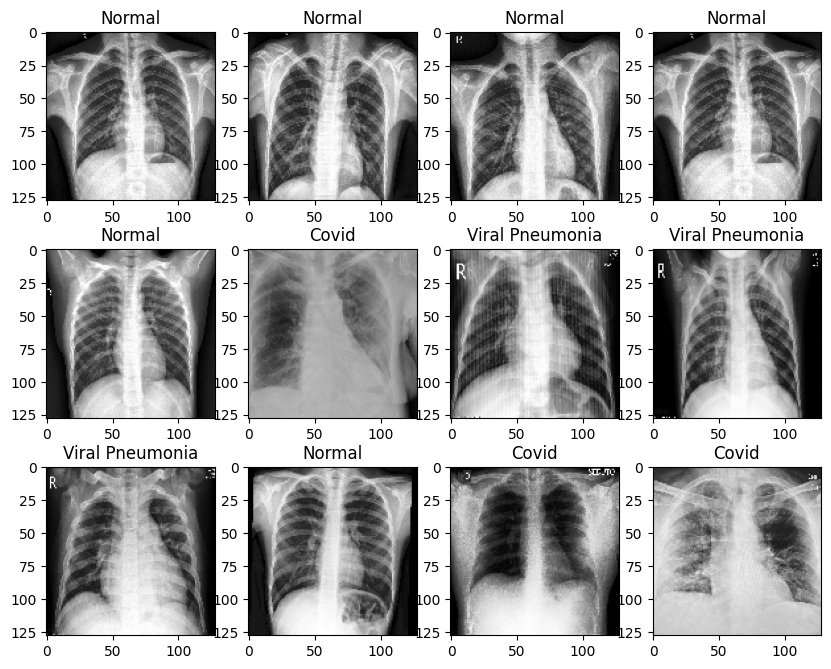

In [7]:
plot_images(images, labels)

<b> Checking for data imbalance

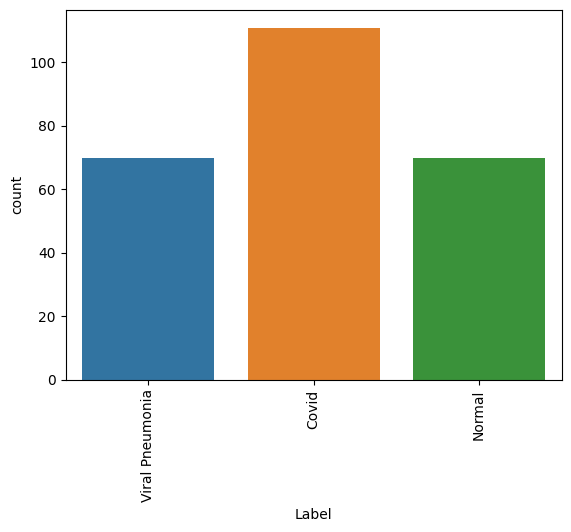

In [8]:
sns.countplot(x=labels['Label']);
plt.xticks(rotation = 'vertical');

- We can observe that the data is not highly imbalanced, but the number of images for the COVID category are somewhat more in comparison to the other two categories. So we can use the appropriate evaluation methods for imbalanced classification like Precision and Recall to evaluate this model.

### **Resizing images**
As the size of the images is large, it may be computationally expensive to train on these larger images; therefore, it is preferable to reduce the image size from 128 to 64.

In [9]:
images_decreased = []

height = 64
width = 64

dimensions = (width, height)

for i in range(len(images)):
  images_decreased.append( cv2.resize(images[i], dimensions, interpolation = cv2.INTER_LINEAR))

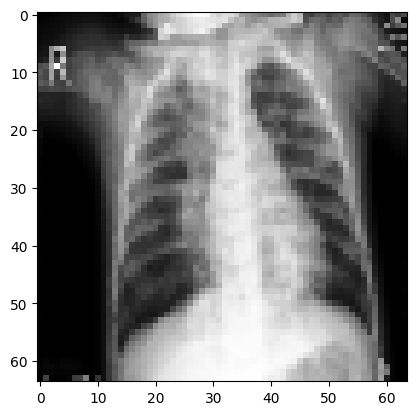

In [10]:
plt.imshow(images_decreased[3])

## **Splitting the dataset**

- As we have a lesser number of images in our dataset, we will use 10% of our data for testing and 90% of our data for training.
- We are using the train_test_split() function from scikit-learn. Here, we split the dataset while keeping the test size constant at 0.1. This means that 10% of total data is used for testing, while 90% is used for training.


In [11]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(np.array(images_decreased), labels, test_size = 0.1, random_state = 42, stratify = labels)

In [12]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(225, 64, 64, 3) (225, 1)
(26, 64, 64, 3) (26, 1)


## **Making the data compatible:**

- Converting the labels from names to one hot vectors
- Normalizing the values


## **Encoding the target labels**

Since this is a 3-class classification problem, the output layer should have 3 neurons, which will provide us with the probabilities of the input image belonging to each of those 3 classes, by using the Softmax activation function. Therefore, we also need to create a one-hot encoded representation for the target classes.

In [13]:
# Convert labels from names to one hot vectors.
# We have already used encoding methods like onehotencoder and labelencoder earlier so now we will be using a new encoding method called labelBinarizer.
# Labelbinarizer works similar to onehotencoder

from sklearn.preprocessing import LabelBinarizer

enc = LabelBinarizer()

y_train_encoded = enc.fit_transform(y_train)

y_test_encoded = enc.transform(y_test)

In [14]:
enc.classes_

array(['Covid', 'Normal', 'Viral Pneumonia'], dtype='<U15')

In [15]:
y_train_encoded.shape,y_test_encoded.shape

((225, 3), (26, 3))

## **Data Normalization**

In neural networks, it is always suggested that we normalize the feature inputs. Normalization has the below benefits while training a neural network model:

- Normalization makes the training faster and reduces the chances of getting stuck at local optima.
- Also, weight decay and estimation can be done more conveniently with normalized inputs.
- In deep neural networks, normalization helps to avoid exploding gradient problems. The exploding gradient problem occurs when large error gradients accumulate and result in very large updates to neural network model weights during training. This makes a model unstable and unable to learn from the training data.

**As we know, image pixel values range from 0 - 255, so we are simply dividing all the pixel values by 255 to standardize all the images to have values between 0 - 1.**

In [16]:
# Normalizing the image pixels
X_train_normalized = X_train.astype('float32')/255.0

X_test_normalized = X_test.astype('float32')/255.0

## **Model Building - Convolutional Neural Network (CNN)**
Let's create a CNN model sequentially, where we will be adding the layers one after another.



*   First, we need to clear the previous model's history from the session even if a single model can run multiple times on the same data.
*   Then, we will fix the seed value.

By setting the **seed for random number generators in Numpy, the Random library in Python, and in TensorFlow**, we will be able to reproduce the same results every time we run the code.

In [17]:
# Clearing backend
from tensorflow.keras import backend

backend.clear_session()

# Fixing the seed for random number generators
import random

np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

Now, let's build a **CNN Model** with the following 2 main parts: <br>

1. **The Feature Extraction layers** which are comprised of convolutional and pooling layers.
2. **The Fully Connected classification layers** for prediction.<br>

In [18]:
# Intializing a sequential model
model1 = Sequential()

# Adding first conv layer with 64 filters and kernel size 3x3 , padding 'same' provides the output size same as the input size
# Input_shape denotes input image dimension of images
model1.add(Conv2D(128, (3, 3), activation = 'relu', padding = "same", input_shape = (64, 64, 3)))

# Adding max pooling to reduce the size of output of first conv layer
model1.add(MaxPooling2D((2, 2), padding = 'same'))

model1.add(Conv2D(64, (3, 3), activation = 'relu', padding = "same"))
model1.add(MaxPooling2D((2, 2), padding = 'same'))

# flattening the output of the conv layer after max pooling to make it ready for creating dense connections
model1.add(Flatten())

# Adding a fully connected dense layer with 100 neurons
model1.add(Dense(8, activation = 'relu'))
model1.add(Dropout(0.3))

# Adding the output layer with 3 neurons and activation functions as softmax since this is a multi-class classification problem
model1.add(Dense(3, activation = 'softmax'))

# Using SGD Optimizer
# opt = SGD(learning_rate = 0.01, momentum = 0.9)
opt=Adam()

# Compile model
model1.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics = ['accuracy'])

# Generating the summary of the model
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 128)       3584      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 128)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        73792     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 16384)             0         
                                                                 
 dense (Dense)               (None, 8)                 1

### <b> Fitting the model on the train data

In [19]:
history_1 = model1.fit(
            X_train_normalized, y_train_encoded,
            epochs = 10,
            validation_split = 0.1,
            shuffle = False,
            batch_size = 64,
            verbose = 1
)

Epoch 1/10
4/4 [==============================] - 12s 171ms/step - loss: 1.1048 - accuracy: 0.3317 - val_loss: 1.0980 - val_accuracy: 0.4348
Epoch 2/10
4/4 [==============================] - 0s 23ms/step - loss: 1.1051 - accuracy: 0.3762 - val_loss: 1.0975 - val_accuracy: 0.4348
Epoch 3/10
4/4 [==============================] - 0s 24ms/step - loss: 1.0980 - accuracy: 0.4406 - val_loss: 1.0971 - val_accuracy: 0.4348
Epoch 4/10
4/4 [==============================] - 0s 23ms/step - loss: 1.0977 - accuracy: 0.4406 - val_loss: 1.0966 - val_accuracy: 0.4348
Epoch 5/10
4/4 [==============================] - 0s 22ms/step - loss: 1.0974 - accuracy: 0.4406 - val_loss: 1.0961 - val_accuracy: 0.4348
Epoch 6/10
4/4 [==============================] - 0s 23ms/step - loss: 1.0972 - accuracy: 0.4406 - val_loss: 1.0956 - val_accuracy: 0.4348
Epoch 7/10
4/4 [==============================] - 0s 22ms/step - loss: 1.0969 - accuracy: 0.4406 - val_loss: 1.0951 - val_accuracy: 0.4348
Epoch 8/10
4/4 [=========

### **Model Evaluation**

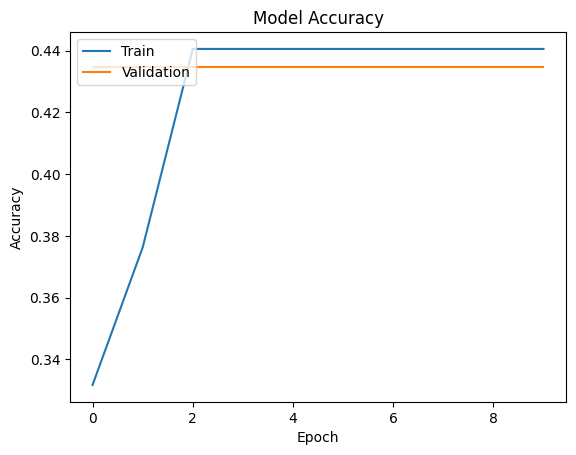

In [20]:
plt.plot(history_1.history['accuracy'])
plt.plot(history_1.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc = 'upper left')
plt.show()

**Observations:**
*   We can see from the above plot that **the training accuracy of the  model was not good and the validation accuracy was also not good.**
*   This shows that the model is not stable and not performing well.
* Let's check the model performance on the test set.





### **Evaluating the model on test data**

In [21]:
accuracy = model1.evaluate(X_test_normalized, y_test_encoded, verbose = 2)

1/1 - 0s - loss: 1.0950 - accuracy: 0.4615 - 181ms/epoch - 181ms/step


### **Plotting the Confusion Matrix**





*   The Confusion matrix expects categorical data as input. However, y_test_encoded is an encoded value, whereas y_pred has probabilities. So,we must retrieve the categorical values from the encoded values.
*   We will use the `argmax()` function to obtain the maximum value over each category on both y_test_encoded and y_pred and obtain their respective classes.





In [22]:
# Getting the output as probablities for each category
y_pred = model1.predict(X_test_normalized)

1/1 [==============================] - 0s 138ms/step


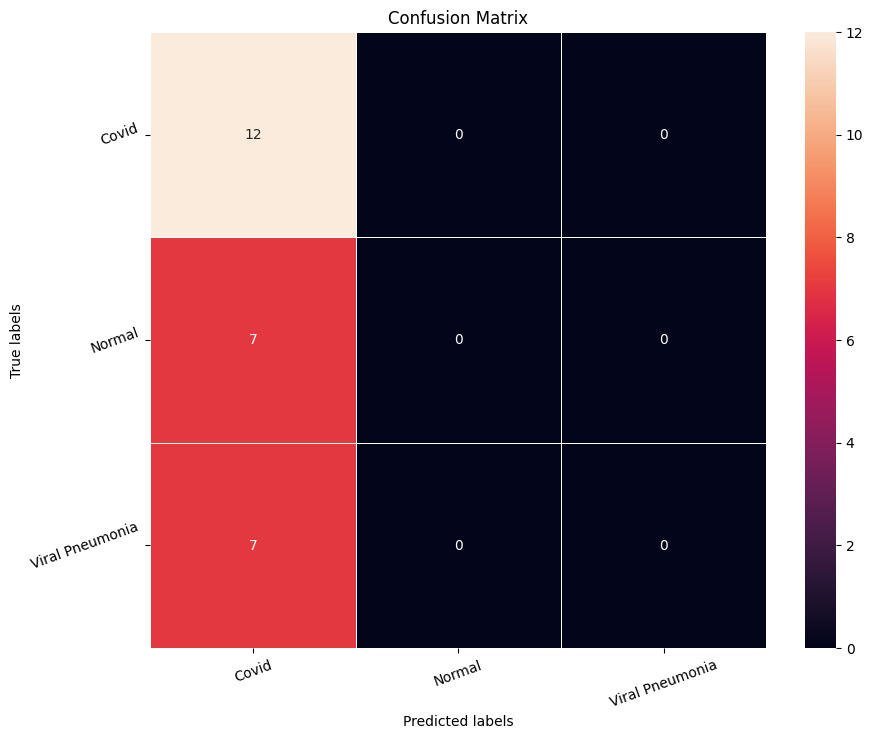

In [23]:
# Obtaining the categorical values from y_test_encoded and y_pred
y_pred_arg = np.argmax(y_pred, axis = 1)
y_test_arg = np.argmax(y_test_encoded, axis = 1)

# Plotting the Confusion Matrix using confusion matrix() function which is also predefined in tensorflow module
confusion_matrix = tf.math.confusion_matrix(y_test_arg, y_pred_arg)
f, ax = plt.subplots(figsize = (10, 8))
sns.heatmap(
    confusion_matrix,
    annot = True,
    linewidths = .4,
    fmt = "d",
    square = True,
    ax = ax
)
# Setting the labels to both the axes
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(['Covid', 'Normal', 'Viral Pneumonia'], rotation = 20)
ax.yaxis.set_ticklabels(['Covid', 'Normal', 'Viral Pneumonia'], rotation = 20)
plt.show()

<b> Observations</b><br>

- In comparison to the rest, we can see that classes Normal and Viral Pneumonia are often misclassified. There are a few cases that are normal but are predicted to have COVID and a few cases that are Viral Pneumonia but are predicted to be normal.
- The COVID category seems to be predicted well but we need to build a model which would also classify the Normal and Viral Pneumonia classes correctly.
- We can observe that the model does not confuse Viral Pneumonia and COVID, which is a good thing. Also, most of the images with the COVID class are predicted correctly, and this is the most desired output since a patient having COVID should never be misclassified with other classes as being healthy or only having a viral fever.

<b> Deleting the model and history variable to use the RAM efficiently

In [24]:
del model1
del history_1

# **Using Data Augmentation to check if it can improve over the Base Model**




**Reducing the Learning Rate:**

**ReduceLRonPlateau()** is a function that will be used to decrease the learning rate by some factor if the loss is not decreasing for some time. This may start decreasing the loss at a smaller learning rate. There is a possibility that the loss may still not decrease. This may lead to executing the learning rate reduction again in an attempt to achieve a lower loss.

In [25]:
from keras.callbacks import ReduceLROnPlateau

learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_accuracy',
                                            patience = 3,
                                            verbose = 1,
                                            factor = 0.5,
                                            min_lr = 0.0001)


### **Data Augmentation**


Remember, **data augmentation should not be used in the validation/test data set**.

In [26]:
# Clearing backend
from tensorflow.keras import backend
backend.clear_session()

# Fixing the seed for random number generators
import random
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [27]:
# Creating the data generator
datagen_train = ImageDataGenerator(
                              rotation_range = 20,
                              fill_mode = 'nearest',
                              )


In [28]:
# Intializing a sequential model
model2 = Sequential()

# Adding first conv layer with 64 filters and kernel size 3x3 , padding 'same' provides the output size same as the input size
# Input_shape denotes input image dimension images
model2.add(Conv2D(16, (3, 3), activation = 'relu', padding = "same", input_shape = (64, 64, 3)))

# Adding max pooling to reduce the size of output of first conv layer
model2.add(MaxPooling2D((2, 2), padding = 'same'))

model2.add(Conv2D(8, (3, 3), activation = 'relu', padding = "same"))
model2.add(MaxPooling2D((2, 2), padding = 'same'))

model2.add(BatchNormalization())
# flattening the output of the conv layer after max pooling to make it ready for creating dense connections
model2.add(Flatten())

# Adding a fully connected dense layer with 100 neurons
model2.add(Dense(16, activation = 'relu'))
model2.add(Dropout(0.3))

# Adding the output layer with 3 neurons and activation functions as softmax since this is a multi-class classification problem
model2.add(Dense(3, activation = 'softmax'))

# Using SGD Optimizer
# opt = SGD(learning_rate = 0.01, momentum = 0.9)
opt=Adam(learning_rate = 0.001)

# Compile model
model2.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics = ['accuracy'])

# Generating the summary of the model
model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 8)         1160      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 8)        0         
 2D)                                                             
                                                                 
 batch_normalization (BatchN  (None, 16, 16, 8)        32        
 ormalization)                                                   
                                                        

In [29]:
# Epochs
epochs = 10

# Batch size
batch_size = 64

history = model2.fit(datagen_train.flow(X_train_normalized, y_train_encoded,
                                       batch_size = batch_size,
                                       shuffle = False),
                                       epochs = epochs,
                                       steps_per_epoch = X_train_normalized.shape[0] // batch_size,
                                       validation_data = (X_test_normalized, y_test_encoded),
                                       verbose = 1, callbacks = [learning_rate_reduction])

Epoch 1/10
3/3 [==============================] - 4s 403ms/step - loss: 1.0931 - accuracy: 0.4534 - val_loss: 1.0900 - val_accuracy: 0.2692 - lr: 0.0010
Epoch 2/10
3/3 [==============================] - 0s 145ms/step - loss: 0.7891 - accuracy: 0.6584 - val_loss: 1.1013 - val_accuracy: 0.4231 - lr: 0.0010
Epoch 3/10
3/3 [==============================] - 0s 173ms/step - loss: 0.5992 - accuracy: 0.7578 - val_loss: 1.1238 - val_accuracy: 0.3846 - lr: 0.0010
Epoch 4/10
3/3 [==============================] - 0s 78ms/step - loss: 0.5762 - accuracy: 0.7516 - val_loss: 1.1368 - val_accuracy: 0.3846 - lr: 0.0010
Epoch 5/10
3/3 [==============================] - ETA: 0s - loss: 0.4901 - accuracy: 0.7764
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
3/3 [==============================] - 0s 103ms/step - loss: 0.4901 - accuracy: 0.7764 - val_loss: 1.1476 - val_accuracy: 0.2692 - lr: 0.0010
Epoch 6/10
3/3 [==============================] - 0s 76ms/step - loss: 0.3896 -

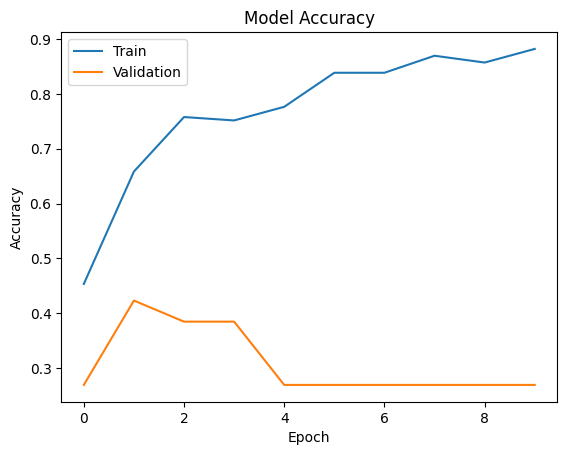

In [30]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc = 'upper left')
plt.show()

In [31]:
accuracy = model2.evaluate(X_test_normalized, y_test_encoded, verbose = 2)

1/1 - 0s - loss: 1.1161 - accuracy: 0.2692 - 24ms/epoch - 24ms/step


In [32]:
# Here we would get the output as probablities for each category
y_pred = model2.predict(X_test_normalized)

1/1 [==============================] - 0s 113ms/step


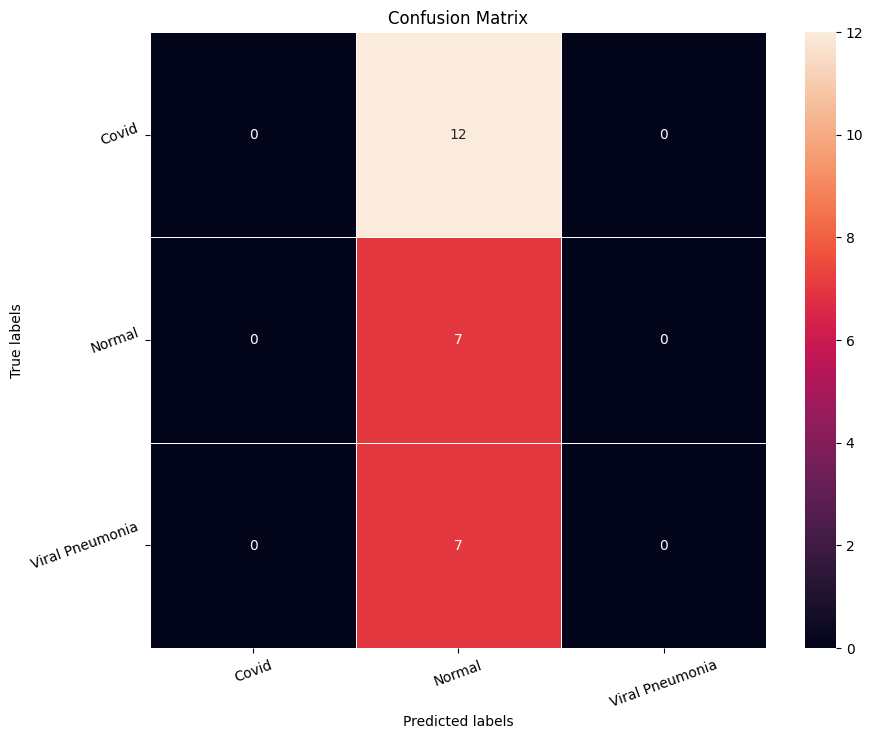

In [33]:
# Obtaining the categorical values from y_test_encoded and y_pred
y_pred_arg = np.argmax(y_pred, axis = 1)
y_test_arg = np.argmax(y_test_encoded,axis = 1)

# Plotting the Confusion Matrix using confusion matrix() function which is also predefined tensorflow module
confusion_matrix = tf.math.confusion_matrix(y_test_arg, y_pred_arg)

f, ax = plt.subplots(figsize = (10, 8))

sns.heatmap(
    confusion_matrix,
    annot = True,
    linewidths = .4,
    fmt = "d",
    square = True,
    ax = ax
)

# Setting the labels to both the axes
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(['Covid', 'Normal', 'Viral Pneumonia'], rotation = 20)
ax.yaxis.set_ticklabels(['Covid', 'Normal', 'Viral Pneumonia'], rotation = 20)
plt.show()

**Observations:**
- We can observe that the model has predicted most cases having covid to be normal. This can be fatal, if a patient having severe case of Covid is to be classified as being normal.
- Hence we cannot accept this model and we have to look at alternative architectures.


## **Visualizing the prediction:**

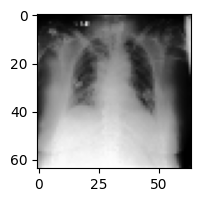

1/1 [==============================] - 0s 153ms/step
Predicted Label ['Normal']
True Label Covid


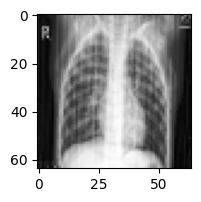

1/1 [==============================] - 0s 20ms/step
Predicted Label ['Normal']
True Label Viral Pneumonia


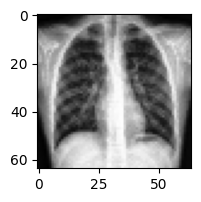

1/1 [==============================] - 0s 20ms/step
Predicted Label ['Normal']
True Label Normal


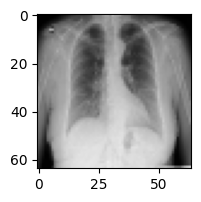

1/1 [==============================] - 0s 21ms/step
Predicted Label ['Normal']
True Label Covid


In [34]:

# Visualizing the predicted and correct label of images from test data
plt.figure(figsize = (2, 2))
plt.imshow(X_test[2])
plt.show()
print('Predicted Label', enc.inverse_transform(model2.predict((X_test_normalized[2].reshape(1, 64, 64, 3)))))   # reshaping the input image as we are only trying to predict using a single image
print('True Label', enc.inverse_transform(y_test_encoded)[2])                                                   # using inverse_transform() to get the output label from the output vector

plt.figure(figsize = (2, 2))
plt.imshow(X_test[10])
plt.show()
print('Predicted Label', enc.inverse_transform(model2.predict((X_test_normalized[10].reshape(1, 64, 64, 3)))))  # reshaping the input image as we are only trying to predict using a single image
print('True Label', enc.inverse_transform(y_test_encoded)[10])                                                  # using inverse_transform() to get the output label from the output vector

plt.figure(figsize = (2, 2))
plt.imshow(X_test[20], )
plt.show()
print('Predicted Label', enc.inverse_transform(model2.predict((X_test_normalized[20].reshape(1, 64, 64, 3)))))  # reshaping the input image as we are only trying to predict using a single image
print('True Label', enc.inverse_transform(y_test_encoded)[20])                                                  # using inverse_transform() to get the output label from the output vector

plt.figure(figsize = (2, 2))
plt.imshow(X_test[5])
plt.show()
print('Predicted Label', enc.inverse_transform(model2.predict((X_test_normalized[5].reshape(1, 64, 64, 3)))))  # reshaping the input image as we are only trying to predict using a single image
print('True Label', enc.inverse_transform(y_test_encoded)[5])                                                  # using inverse_transform() to get the output label from the output vector

**Observations**

- We observe that all the above images were classified correctly.
- This shows that data augmentation has helped in creating a generalized model.

<b> Now let us try to use a pretrained model like VGG16 and check how it performs on our data.

In [35]:
# Clearing backend
from tensorflow.keras import backend
backend.clear_session()

# Fixing the seed for random number generators
np.random.seed(42)
import random
random.seed(42)
tf.random.set_seed(42)

In [36]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras import Model

vgg = VGG16(include_top = False, weights = 'imagenet', input_shape = (64, 64, 3))
vgg.summary()

58889256/58889256 [==============================] - 4s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                              

In [37]:
transfer_layer = vgg.get_layer('block5_pool')

vgg.trainable = False

# Add classification layers on top of it

x = Flatten()(transfer_layer.output) # Flatten the output from the 3rd block of the VGG16 model
x = Dense(256, activation = 'relu')(x)
x = Dense(128, activation = 'relu')(x)
x = Dropout(0.3)(x)


x = Dense(64, activation = 'relu')(x)
x = BatchNormalization()(x)

pred = Dense(3, activation = 'softmax')(x)

model3 = Model(vgg.input, pred) # Initializing the model

In [38]:
# Compiling the model
model3.compile(loss = 'binary_crossentropy',
              optimizer = tf.keras.optimizers.Adamax(learning_rate = 0.001),
              metrics = ['accuracy'])

Let's re use the augmented data generators we built for model 2.

In [39]:
# Epochs
epochs = 10

# Batch size
batch_size = 64

history = model3.fit(datagen_train.flow(X_train_normalized, y_train_encoded,
                                       batch_size = batch_size,
                                       shuffle = False),
                                       epochs = epochs,
                                       steps_per_epoch = X_train_normalized.shape[0] // batch_size,
                                       validation_data = (X_test_normalized, y_test_encoded),
                                       verbose = 1)

Epoch 1/10
3/3 [==============================] - 7s 1s/step - loss: 0.8000 - accuracy: 0.3478 - val_loss: 0.5592 - val_accuracy: 0.6154
Epoch 2/10
3/3 [==============================] - 1s 195ms/step - loss: 0.5775 - accuracy: 0.6770 - val_loss: 0.4965 - val_accuracy: 0.6154
Epoch 3/10
3/3 [==============================] - 0s 145ms/step - loss: 0.4857 - accuracy: 0.7640 - val_loss: 0.4509 - val_accuracy: 0.7692
Epoch 4/10
3/3 [==============================] - 0s 112ms/step - loss: 0.4627 - accuracy: 0.7391 - val_loss: 0.4198 - val_accuracy: 0.8462
Epoch 5/10
3/3 [==============================] - 0s 93ms/step - loss: 0.3907 - accuracy: 0.8323 - val_loss: 0.3893 - val_accuracy: 0.8846
Epoch 6/10
3/3 [==============================] - 0s 114ms/step - loss: 0.3627 - accuracy: 0.8571 - val_loss: 0.3622 - val_accuracy: 0.8846
Epoch 7/10
3/3 [==============================] - 0s 118ms/step - loss: 0.3811 - accuracy: 0.8447 - val_loss: 0.3415 - val_accuracy: 0.8846
Epoch 8/10
3/3 [========

In [40]:
accuracy = model3.evaluate(X_test_normalized, y_test_encoded, verbose = 2)

1/1 - 0s - loss: 0.3276 - accuracy: 0.9231 - 41ms/epoch - 41ms/step


In [41]:
# Here we would get the output as probablities for each category
y_pred = model3.predict(X_test_normalized)

1/1 [==============================] - 0s 258ms/step


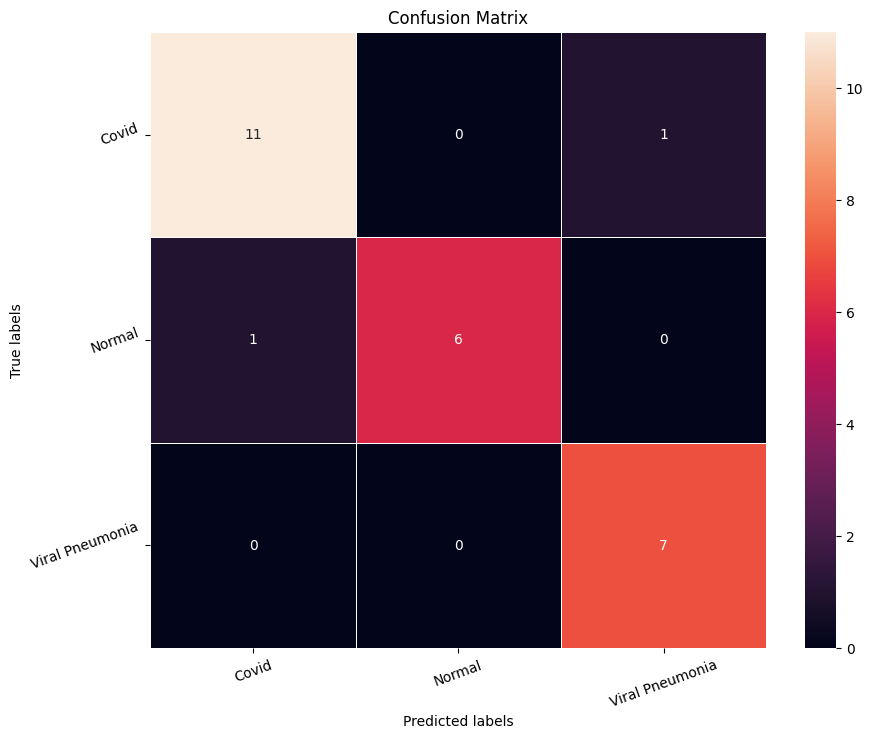

In [42]:
# Obtaining the categorical values from y_test_encoded and y_pred
y_pred_arg = np.argmax(y_pred, axis = 1)
y_test_arg = np.argmax(y_test_encoded,axis = 1)

# Plotting the Confusion Matrix using confusion matrix() function which is also predefined tensorflow module
confusion_matrix = tf.math.confusion_matrix(y_test_arg, y_pred_arg)

f, ax = plt.subplots(figsize = (10, 8))

sns.heatmap(
    confusion_matrix,
    annot = True,
    linewidths = .4,
    fmt = "d",
    square = True,
    ax = ax
)

# Setting the labels to both the axes
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(['Covid', 'Normal', 'Viral Pneumonia'], rotation = 20)
ax.yaxis.set_ticklabels(['Covid', 'Normal', 'Viral Pneumonia'], rotation = 20)
plt.show()

**Observations:**




- We observe that our Transfer Learning model is the best model so far, as it has predicted the majority of the classes correctly with minimum misclassifications.
- The Transfer Learning model showed the best results in training, and also has the best accuracy during testing.
- Data Augmentation has also helped in improving the overall model performance.

## **Conclusion**

- Convolutional Neural Networks (CNNs), as we see above, are able to excel at making predictions on images.
- CNNs do this to a greater level than statistical Machine Learning techniques and Artificial Neural Networks (ANNs), because those algorithms flatten the spatial structure of an image right at the start, whereas CNNs only do so after applying a series of feature extraction steps on the image, such as Convolutions, Pooling, Padding, and non-linear Activation Functions.
- Some of the reasons CNNs are advantageous over ANNs in making predictions on image data, are Spatial and Translational Invariance, the ability to extract important features and discard unimportant ones, and their relative computational efficiency over ANNs.
- Medical research has been a domain that has benefited greatly from the ability of CNNs in image prediction tasks. The best CNNs, with architectural modifications necessary for the unique use cases of the medical domain, have been shown to rival and sometimes even surpass the performance of experienced radiologists at tasks like tumor detection, and can hence serve as a useful source of second opinion for medical professionals in diagnosis and decision-making.
- Being able to automate this task using CNNs would represent benefits such as the ability to provide faster observations than a human, and the ability to handle a larger volume of the same task. Secondly, as a piece of software, it could be distributed anywhere in the world, including in less well-connected regions of the world that may not have access to experts capable of such diagnoses from X-ray scans.
- However, Deep Learning based solutions have a few hurdles to overcome before mainstream acceptance. Their lack of explainability, their brittleness and susceptibility to small perturbations in images, and the need to achieve very high performance on evaluation metrics for acceptance, makes it difficult to currently use them as a singular source of truth, and they can only be considered as a part of the decision-making process in assistance to medical professionals qualified for these operations.

# **Happy Learning!**